In [1]:
import warnings
import os
import networkx as nx
import numpy as np
os.environ['DGLBACKEND'] = 'pytorch'
from ogb.nodeproppred import DglNodePropPredDataset, Evaluator
import pandas as pd
from plotly import express as px
from plotly import graph_objects as go
import pytorch_lightning as pl
import torch
import torch.nn.functional as F
from data import DataModule
from models import GCN, GAT


torch.set_float32_matmul_precision('medium')
warnings.filterwarnings("ignore")

def compute_acc(pred, labels, evaluator):
    return evaluator.eval(
        {"y_pred": pred.argmax(dim=-1, keepdim=True), "y_true": labels}
    )["acc"]

def compute_accuracy_train_val_test(pred, labels, idx, split_idx):
    return {
        f"{stage}_acc": compute_acc(
            pred[split_idx[stage]],
            labels[split_idx[stage]],
            evaluator=Evaluator(name="ogbn-arxiv"),
        )
        for stage in ["train", "valid", "test"]
    }

fig = go.FigureWidget(px.line(pd.DataFrame({'train': [0], 'valid': [0], 'test': [0]}), range_x=[0, 100]))

def update_figure(trainer, _):
    for line in fig.data:
        line.y = np.append(line.y, trainer.callback_metrics[f'{line.legendgroup}_acc'].cpu())
        line.x = np.append(line.x, trainer.current_epoch)
        
def draw_networkx_plotly(G, edges, layout, metadata=None, **kwargs):
    coords = pd.DataFrame(
        {'id': pd.concat([edges['source'], edges['target']])}).sort_index(kind='merge')
    for i, axis in enumerate(['x', 'y']):
           coords[axis] = coords['id'].apply(lambda x: layout[x][i])
    if metadata is not None:
        coords = coords.reset_index().merge(metadata, on='id').set_index('index')
    coords = pd.concat([coords, pd.DataFrame(
        {'id': [None]*(len(coords) // 2)})]).sort_index(kind='merge')
    hover_data = [c for c in coords.columns if c not in ['x', 'y']]
    fig = px.line(coords, x='x', y='y', hover_data=hover_data, markers=True, **kwargs)
    if 'color' not in kwargs:
        fig.update_traces(line_color='#aaaaaa', marker_color='#000000')
    return fig

def edges_for_hops(graph, G, source_id, max_per_hop, device):
    n_hops = len(max_per_hop)
    path_lengths = nx.single_source_shortest_path_length(
        G.to_undirected(), source_id, cutoff=n_hops)
    shells = pd.DataFrame(path_lengths.items()).groupby(1)[0].apply(list).tolist()
    subgraph = nx.Graph(nx.induced_subgraph(G, path_lengths.keys()))
    edges = (nx.to_pandas_edgelist(subgraph)[["source", "target"]]
        .sample(n=sum(max_per_hop)))
    layout = nx.shell_layout(subgraph, shells)
    return edges, layout

In [2]:
data = DglNodePropPredDataset("ogbn-arxiv")
graph, labels = data[0]
G = graph.to_networkx()
split_idx = data.get_idx_split()
n_classes = data.num_classes
datamodule = DataModule(
    use_labels=True,
    split_idx=split_idx,
    labels=labels,
    graph=graph,
    n_classes=n_classes,
)

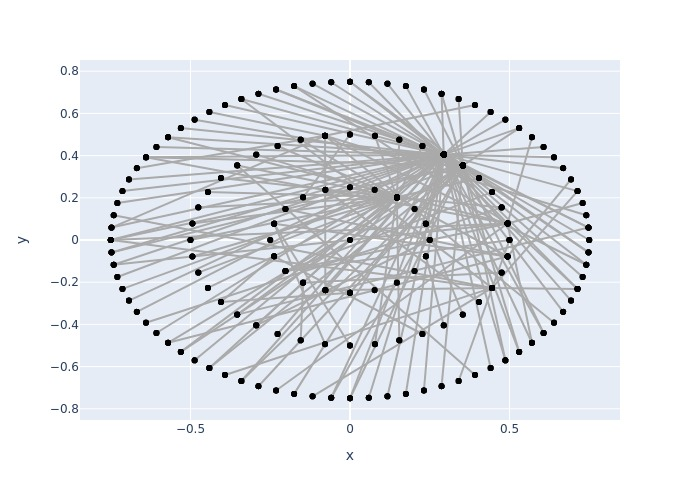

In [3]:
source_id = 0
max_per_hop = [20, 40, 80]
edges, layout = edges_for_hops(graph, G, source_id, max_per_hop, device='cpu')
metadata = pd.DataFrame.from_dict([{
    'id': node_id,
    'degree': G.degree(node_id),
    'label': labels[node_id].item(),
} for node_id in np.unique(edges).tolist()])
draw_networkx_plotly(G, edges, layout, metadata)

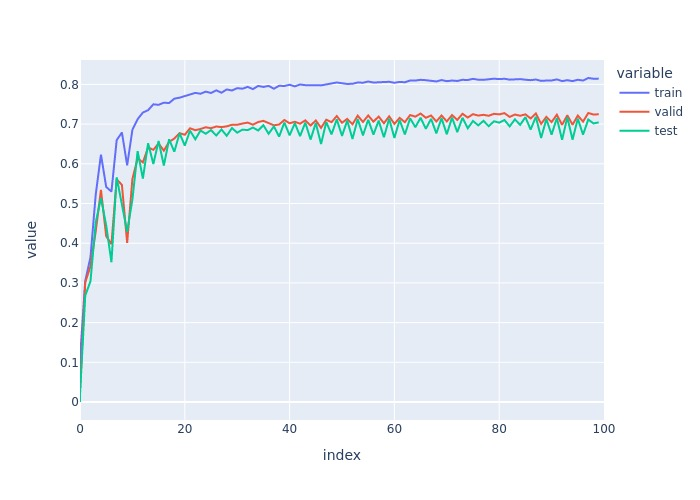

In [8]:
accuracy = lambda pred, labels, idx: compute_accuracy_train_val_test(
    pred, labels, idx, split_idx
)

model = GCN(
    in_feats=graph.ndata["feat"].shape[1] + n_classes,
    n_classes=n_classes,
    n_hidden=256,
    n_layers=3,
    activation=F.relu,
    dropout=0.75,
    use_linear=False,
    val_metric=accuracy,
)
fig

In [7]:
trainer = pl.Trainer(
    accelerator="auto",
    max_epochs=100,
    callbacks=[pl.callbacks.LambdaCallback(
        on_train_epoch_end=update_figure
    )],
    enable_progress_bar=False,
)
trainer.fit(model, datamodule=datamodule)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name     | Type       | Params
----------------------------------------
0 | convs    | ModuleList | 118 K 
1 | bns      | ModuleList | 1.0 K 
2 | dropout0 | Dropout    | 0     
3 | dropout  | Dropout    | 0     
----------------------------------------
119 K     Trainable params
0         Non-trainable params
119 K     Total params
0.479     Total estimated model params size (MB)


Total edges after adding self-loop 2501829


`Trainer.fit` stopped: `max_epochs=100` reached.


In [ ]:
n_epochs = 100
n_layers = 3
n_hidden = 256
n_heads = 3
dropout = 0.75
attn_drop = 0.05
norm = "none"  # "both"

model = GAT(
    graph.ndata["feat"].shape[1] + n_classes,
    n_classes,
    n_hidden=n_hidden,
    n_layers=n_layers,
    n_heads=n_heads,
    activation=F.relu,
    dropout=dropout,
    attn_drop=attn_drop,
    norm=norm,
    val_metric=accuracy,
)

trainer = pl.Trainer(
    accelerator="auto",
    max_epochs=100,
    log_every_n_steps=1,
)
trainer.fit(model, datamodule=datamodule)